In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (Conv2D, BatchNormalization, MaxPooling2D,
                                     GlobalAveragePooling2D, Dense, Dropout, TimeDistributed, LSTM)



In [ ]:
csv_path= "C:/Users/fr4nc/OneDrive/Documents/project_stromboli/frames_storici/dataset_pub/metadata_SPT_thermal_images.csv"
root_path = "C:/Users/fr4nc/OneDrive/Documents/project_stromboli/frames_storici/dataset_pub/spt_thermal_images_sequences_dataset/"

BATCH_SIZE = 32
seq_lenght = 100
img_size = (384,384)
classes = 4
epochs = 3

class SequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, base_path, batch_size=32, shuffle=True):
        self.df = df
        self.base_path = base_path
        self.batch_size = batch_size
        self.shuffle = shuffle      
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = (index + 1) * self.batch_size
        batch_df = self.df.iloc[start_index:end_index]

        X = np.empty((self.batch_size, seq_lenght, *img_size, 3), dtype=np.float32)
        Y = np.empty((self.batch_size, seq_lenght, classes), dtype=np.float32)

        for i, (_, row) in enumerate(batch_df.iterrows()):
            for t in range(seq_lenght):
                path_col = f'path_{t}'
                full_path = os.path.join(self.base_path, row[path_col].lstrip('/'))

                img = cv2.imread(full_path)
                if img is None:
                    img_final = np.zeros((*img_size, 3), dtype=np.float32)
                else:                   
                    img_final = cv2.resize(img, img_size)

                X[i, t] = img_final.astype(np.float32) / 255.0

            labels = [row[f'class_{t}'] for t in range(seq_lenght)]
            Y[i] = tf.keras.utils.to_categorical(labels, num_classes=classes)

        return X, Y

In [4]:
df_full = pd.read_csv(csv_path)
train_split = 0.7
df_train = df_full.sample(frac=train_split, random_state=42)
df_val = df_full.drop(df_train.index)

train_generator = SequenceGenerator(df_train, root_path, batch_size=BATCH_SIZE, shuffle=True)
validation_generator = SequenceGenerator(df_val, root_path, batch_size=BATCH_SIZE, shuffle=False)

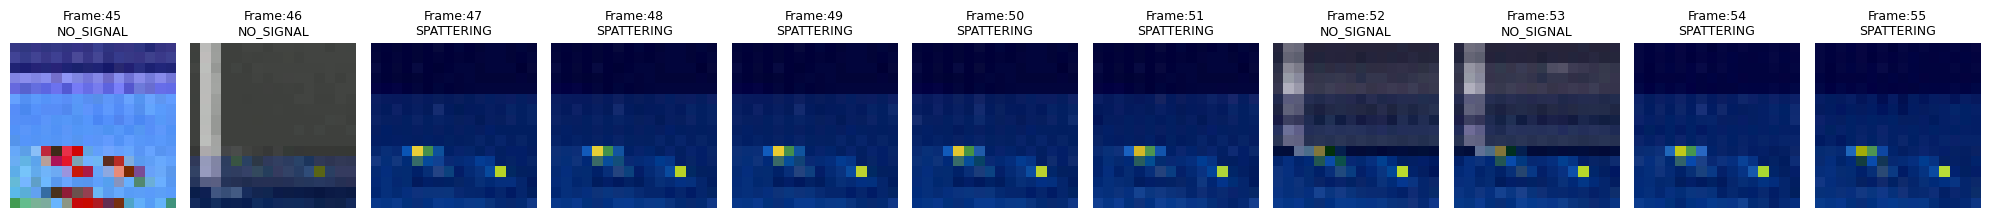

In [6]:
class_names = ['EXPLOSION', 'NO_EXPLOSION', 'NO_SIGNAL', 'SPATTERING']
x, y = next(iter(train_generator)) 

seq_idx = 0        
start_frame = 45     
num_frames = 11  

plt.figure(figsize=(20, 4))

for i in range(num_frames):
    plt.subplot(1, num_frames, i + 1)
    frame_idx = start_frame + i
    plt.imshow(x[seq_idx, frame_idx][..., ::-1], interpolation='none')
    clase_idx = np.argmax(y[seq_idx, frame_idx])
    plt.title("Frame:" +str(frame_idx)+"\n"+str(class_names[clase_idx]), fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:

## Build the cnn model 
def cnn_stromboli_model(input_shape_2d=(16,16,3)):
    inputs = Input(shape=input_shape_2d)

    conv1 = Conv2D(4, (4,4), strides=(2,2), padding='same', activation='relu')(inputs)
    batch1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(batch1)

    conv2 = Conv2D(8, (3,3), strides=(2,2), padding='same', activation='relu')(pool1)
    batch2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(batch2)

    conv3 = Conv2D(256, (3,3), strides=(2,2), padding='same', activation='relu')(pool2)
    batch3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(batch3)

    conv4 = Conv2D(4, (3,3), strides=(2,2), padding='same', activation='relu')(pool3)
    batch4 = BatchNormalization()(conv4)
    pool4 = GlobalAveragePooling2D()(batch4)
     


    flatten1 = Dense(512, activation='relu')(pool4)
    drop1 = Dropout(0.5)(flatten1)

    model = Model(inputs, drop1, name="CNN_model")
    return model

## Build the cnn_LSMT model 

def cnn_lstm_stromboli_model(input_shape, classes):
    input_tensor = Input(shape=input_shape)

    cnn_base_model = cnn_stromboli_model(input_shape_2d=(input_shape[1], input_shape[2], input_shape[3]))
    cnn_base_model.trainable = True

    tdcnn_features = TimeDistributed(cnn_base_model)(input_tensor)

    lstm_1 = LSTM(units=256, return_sequences=True, dropout=0.5)(tdcnn_features)
    lstm_2 = LSTM(units=128, return_sequences=True, dropout=0.5)(lstm_1)
    
    classify = TimeDistributed(Dense(classes, activation='softmax'))(lstm_2)

    model = Model(inputs=input_tensor, outputs=classify)
    return model



input_shape = (seq_lenght, *img_size, 3)
model = cnn_lstm_stromboli_model(input_shape, classes)


print(model.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 16, 16, 3)]  0         
                                                                 
 time_distributed (TimeDistr  (None, 100, 512)         151836    
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 100, 256)          787456    
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 4)           1028      
 tributed)                                                       
                                                                 
Total params: 940,320
Trainable params: 939,784
Non-trainable params: 536
_________________________________________________________________
None


In [8]:
#compiler
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [9]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,

    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('C:/Users/fr4nc/best_model_custom_cnn_lstm_con2019_16x16.keras', save_best_only=True, monitor='val_loss'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    ]
)

Epoch 1/3
72/72 [==============================] - 609s 8s/step - loss: 1.1956 - accuracy: 0.5405 - val_loss: 1.2526 - val_accuracy: 0.6407
Epoch 2/3
72/72 [==============================] - 541s 8s/step - loss: 0.9935 - accuracy: 0.6437 - val_loss: 1.0698 - val_accuracy: 0.6407
Epoch 3/3
72/72 [==============================] - 512s 7s/step - loss: 0.9364 - accuracy: 0.6569 - val_loss: 0.9525 - val_accuracy: 0.6385


📊 Métricas de entrenamiento guardadas en 'training_history.csv'.


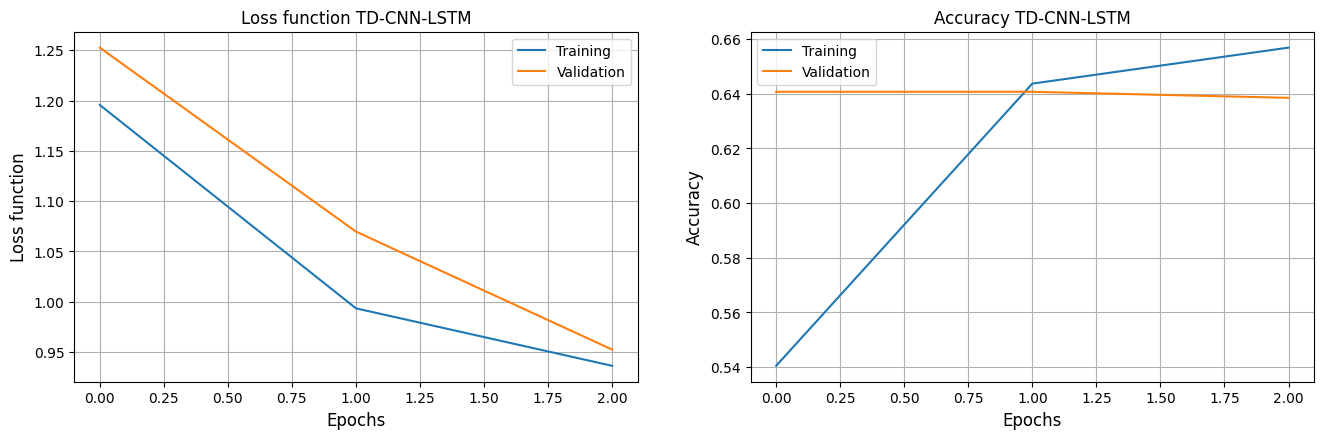

In [ ]:
# --- 2️⃣ PLOTEAR LOSS ---
plt.figure(figsize=(16, 10))
plt.subplot(221)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss function TD-CNN-LSTM')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss function', fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(222)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy TD-CNN-LSTM')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


/n=== CLASSIFICATION REPORT (POR FRAME) ===
              precision    recall  f1-score   support

   EXPLOSION     0.0000    0.0000    0.0000     16223
NO_EXPLOSION     0.6537    0.8043    0.7212     63559
   NO_SIGNAL     0.0275    0.0783    0.0407      7365
  SPATTERING     0.0000    0.0000    0.0000     12053

    accuracy                         0.5211     99200
   macro avg     0.1703    0.2207    0.1905     99200
weighted avg     0.4209    0.5211    0.4651     99200



c:\Users\fr4nc\.conda\envs\tf_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fr4nc\.conda\envs\tf_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fr4nc\.conda\envs\tf_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


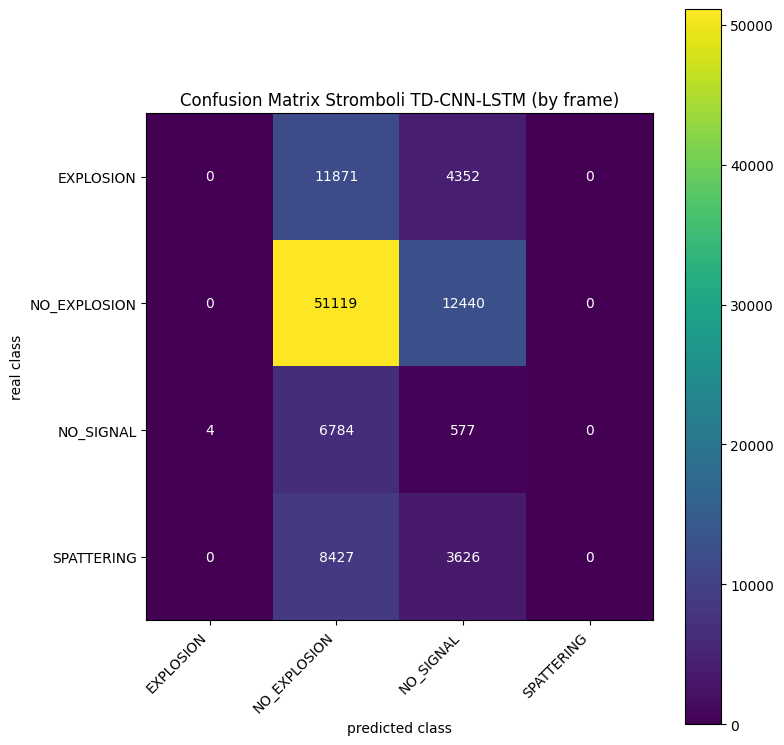

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# =========================
# CONFIGURACIÓN
# =========================
class_names = ['EXPLOSION', 'NO_EXPLOSION', 'NO_SIGNAL', 'SPATTERING']
classes = len(class_names)

# =========================
# FUNCIONES AUXILIARES
# =========================
def y_frames_to_labels(yb):

    yb = np.array(yb)

    if yb.ndim == 3 and yb.shape[-1] == classes:
        return np.argmax(yb, axis=-1).reshape(-1)

    if yb.ndim == 2:
        return yb.reshape(-1).astype(int)

    raise ValueError(f"Forma no soportada para y_batch: {yb.shape}")


def preds_frames_to_labels(pb):
    pb = np.array(pb)

    if pb.ndim == 3 and pb.shape[-1] == classes:
        return np.argmax(pb, axis=-1).reshape(-1)

    raise ValueError(f"Forma no soportada para preds: {pb.shape}")


def frames_to_sequence_labels(labels_flat, B, seq_lenght):
    
    labels_flat = np.array(labels_flat).reshape(B, seq_lenght)
    seq_labels = []

    for b in range(B):
        cnt = Counter(labels_flat[b].tolist())
        seq_labels.append(cnt.most_common(1)[0][0])

    return np.array(seq_labels, dtype=int)


def plot_cm_like_photo(cm, class_names, title,
                       figsize=(8, 8), cmap="viridis"):

    cm = np.asarray(cm)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)

    # Colorbar
    fig.colorbar(im, ax=ax)

    # Ticks y etiquetas
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)

    ax.set_xlabel("predicted class")
    ax.set_ylabel("real class")
    ax.set_title(title)

    # Texto en celdas
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if cm[i, j] < thresh else "black"
            ax.text(j, i, f"{cm[i, j]:d}",
                    ha="center", va="center", color=color)

    ax.grid(False)
    plt.tight_layout()
    plt.show()

# ==========================================================
# 1) MATRIZ DE CONFUSIÓN POR FRAME
# ==========================================================
y_true_frames_all = []
y_pred_frames_all = []

for i in range(len(validation_generator)):
    Xb, yb = validation_generator[i]

    pb = model.predict(Xb, verbose=0)   # (B,seq_lenght,C)

    yt = y_frames_to_labels(yb)         # (B*seq_lenght,)
    yp = preds_frames_to_labels(pb)     # (B*seq_lenght,)

    m = min(len(yt), len(yp))
    y_true_frames_all.append(yt[:m])
    y_pred_frames_all.append(yp[:m])

y_true_frames_all = np.concatenate(y_true_frames_all)
y_pred_frames_all = np.concatenate(y_pred_frames_all)

print("/n=== CLASSIFICATION REPORT (POR FRAME) ===")
print(classification_report(
    y_true_frames_all,
    y_pred_frames_all,
    target_names=class_names,
    digits=4
))

cm_frames = confusion_matrix(
    y_true_frames_all,
    y_pred_frames_all,
    labels=range(classes)
)

plot_cm_like_photo(
    cm_frames,
    class_names,
    title="Confusion Matrix Stromboli TD-CNN-LSTM (by frame)"
)




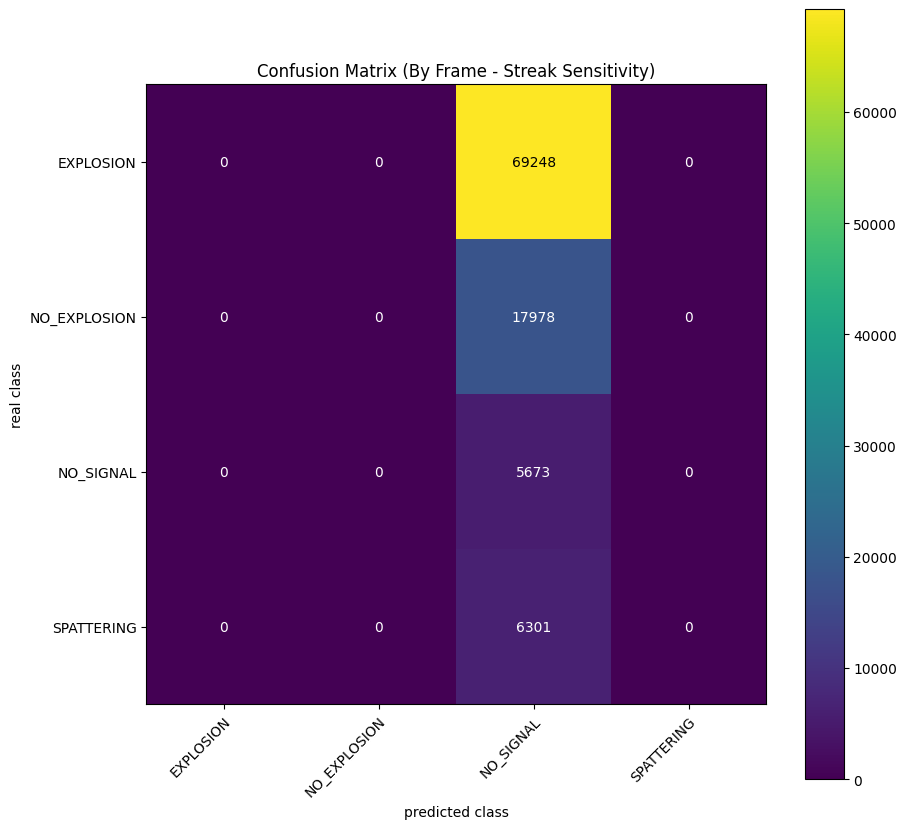

              precision    recall  f1-score   support

   EXPLOSION     0.0000    0.0000    0.0000     69248
NO_EXPLOSION     0.0000    0.0000    0.0000     17978
   NO_SIGNAL     0.0572    1.0000    0.1082      5673
  SPATTERING     0.0000    0.0000    0.0000      6301

    accuracy                         0.0572     99200
   macro avg     0.0143    0.2500    0.0270     99200
weighted avg     0.0033    0.0572    0.0062     99200



c:\Users\fr4nc\.conda\envs\tf_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fr4nc\.conda\envs\tf_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\fr4nc\.conda\envs\tf_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

y_true_frames, y_pred_frames = [], []

for i in range(len(validation_generator)):
    Xb, yb = validation_generator[i]
    pb = model.predict(Xb, verbose=0)
    B, L = pb.shape[0], pb.shape[1] # Batch, Sequence Length
    
    # Obtener etiquetas por frame originales
    yt_f = np.argmax(yb, axis=-1) if yb.ndim == 3 else yb
    yp_f = np.argmax(pb, axis=-1)
    
    # Re-etiquetado por racha: si hay 4 frames de EXPLOSION (idx 0), 
    # marcamos TODA la secuencia (L frames) como EXPLOSION.
    for b in range(B):
        # Lógica para la predicción
        count, found = 0, False
        for val in yp_f[b]:
            if val == 0: # EXPLOSION
                count += 1
                if count >= 4: found = True; break
            else: count = 0
        
        # Si se detectó racha, forzamos todos los frames de esta secuencia a 0
        p_final = np.full(L, 0) if found else yp_f[b]
        
        # Hacemos lo mismo para la realidad (ground truth) para ser consistentes
        count_t, found_t = 0, False
        for val_t in yt_f[b]:
            if val_t == 0:
                count_t += 1
                if count_t >= 4: found_t = True; break
            else: count_t = 0
        t_final = np.full(L, 0) if found_t else yt_f[b]

        y_true_frames.extend(t_final)
        y_pred_frames.extend(p_final)

y_true_all = np.array(y_true_frames)
y_pred_all = np.array(y_pred_frames)

# --- MATRIZ VISUAL ---
cm = confusion_matrix(y_true_all, y_pred_all)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       title='Confusion Matrix (By Frame - Streak Sensitivity)',
       ylabel='real class', xlabel='predicted class')

plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center",
                color="white" if cm[i, j] < (cm.max()/2) else "black")

plt.show()
print(classification_report(y_true_all, y_pred_all, target_names=class_names, digits=4))